In [1]:
! pip install pandas numpy scikit-learn seaborn catboost phik imblearn lightgbm optuna

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.mixture import GaussianMixture
import optuna
from plots import *
from helper import *
import random

d:\soft\creditcard\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
df = pd.read_csv('creditcard.csv')

positive_df = df[df['Class'] == 1]
negative_df = df[df['Class'] == 0]

negative_sample = negative_df.sample(n=50000, random_state=SEED)

balanced_df2 = pd.concat([positive_df, negative_sample], ignore_index=True)

balanced_df2 = balanced_df2.sample(frac=1, random_state=SEED).reset_index(drop=True)

X_balanced, y_balanced = divide_data(balanced_df2, 'Class')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, 
    test_size=0.2, 
    random_state=SEED,
)

In [6]:
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_test, y_test)

In [ ]:
def objective(trial):
    params = {
        "iterations": 2000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128]),
        "random_seed": SEED,
        "early_stopping_rounds": 100,
        "verbose": False,
        "eval_metric": "F1"
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    return model.best_score_["validation"]["F1"]

In [8]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-09-13 14:57:35,208] A new study created in memory with name: no-name-ea2de826-9dc8-4d9c-af7a-20761986c49f
[I 2025-09-13 14:57:36,894] Trial 0 finished with value: 0.9255319148936171 and parameters: {'depth': 7, 'learning_rate': 0.16291925076462582, 'l2_leaf_reg': 9, 'bagging_temperature': 4.105650229505907, 'border_count': 128}. Best is trial 0 with value: 0.9255319148936171.
[I 2025-09-13 14:57:39,369] Trial 1 finished with value: 0.9189189189189189 and parameters: {'depth': 7, 'learning_rate': 0.026131171254041963, 'l2_leaf_reg': 8, 'bagging_temperature': 2.991309190486655, 'border_count': 64}. Best is trial 0 with value: 0.9255319148936171.
[I 2025-09-13 14:57:41,888] Trial 2 finished with value: 0.9255319148936171 and parameters: {'depth': 10, 'learning_rate': 0.15779432900286788, 'l2_leaf_reg': 6, 'bagging_temperature': 4.617007969724556, 'border_count': 32}. Best is trial 0 with value: 0.9255319148936171.
[I 2025-09-13 14:57:42,917] Trial 3 finished with value: 0.91978609

In [9]:
best_params = study.best_params

best_params

{'depth': 6,
 'learning_rate': 0.24131049349308362,
 'l2_leaf_reg': 8,
 'bagging_temperature': 4.8028789429622005,
 'border_count': 128}

In [ ]:
best_model = CatBoostClassifier(**best_params, iterations=2000, random_seed=SEED, early_stopping_rounds=1000)
best_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

0:	learn: 0.2274911	test: 0.2270675	best: 0.2270675 (0)	total: 8.83ms	remaining: 17.6s
1:	learn: 0.0844690	test: 0.0836312	best: 0.0836312 (1)	total: 15.6ms	remaining: 15.6s
2:	learn: 0.0391854	test: 0.0375052	best: 0.0375052 (2)	total: 21.8ms	remaining: 14.5s
3:	learn: 0.0241653	test: 0.0219240	best: 0.0219240 (3)	total: 28.1ms	remaining: 14s
4:	learn: 0.0183192	test: 0.0159093	best: 0.0159093 (4)	total: 34.5ms	remaining: 13.8s
5:	learn: 0.0153960	test: 0.0128256	best: 0.0128256 (5)	total: 40.7ms	remaining: 13.5s
6:	learn: 0.0133299	test: 0.0110431	best: 0.0110431 (6)	total: 47.3ms	remaining: 13.5s
7:	learn: 0.0124976	test: 0.0102825	best: 0.0102825 (7)	total: 54.3ms	remaining: 13.5s
8:	learn: 0.0114939	test: 0.0095312	best: 0.0095312 (8)	total: 61.2ms	remaining: 13.5s
9:	learn: 0.0109302	test: 0.0091033	best: 0.0091033 (9)	total: 68.3ms	remaining: 13.6s
10:	learn: 0.0105098	test: 0.0088781	best: 0.0088781 (10)	total: 74.9ms	remaining: 13.5s
11:	learn: 0.0100521	test: 0.0087036	best: 

In [11]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

ROC AUC: 0.9921
Accuracy: 0.9988
Precision: 0.9778
Recall: 0.8980
F1: 0.9362


In [12]:
from sklearn.metrics import precision_recall_fscore_support


precisions, recalls, f1s, supports = precision_recall_fscore_support(y_test, y_pred, average=None)

df_metrics = pd.DataFrame({
    "Class": [0, 1],
    "Precision": precisions,
    "Recall": recalls,
    "F1": f1s,
    "Support": supports
})

df_metrics

,Class,Precision,Recall,F1,Support
0,0,0.999001,0.999800,0.99940,10001
1,1,0.977778,0.897959,0.93617,98


теперь охват составляет 87%, вместо 80%

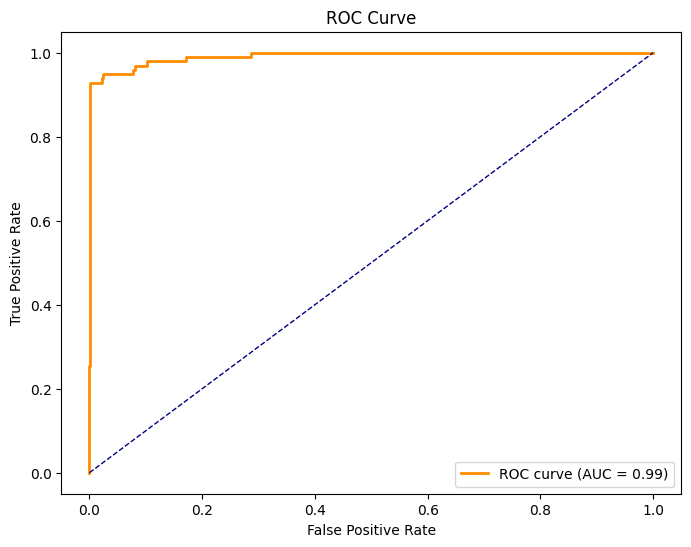

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

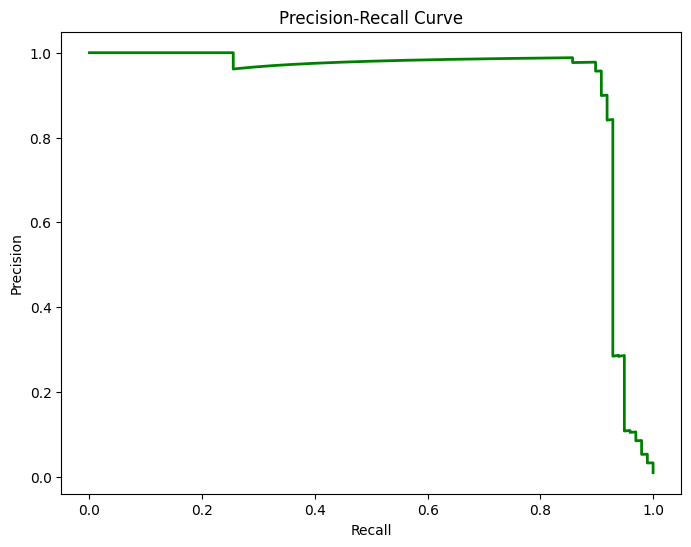

In [14]:
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()